# 0. Preparation

## 0.1 Imports

In [1]:
import os
from os.path import exists
import torch
import torch.nn as nn
from torch.nn.functional import log_softmax, pad
import math
import copy
import time
from torch.optim.lr_scheduler import LambdaLR
import pandas as pd
import altair as alt
from torchtext.data.functional import to_map_style_dataset
from torch.utils.data import DataLoader
from torchtext.vocab import build_vocab_from_iterator
import torchtext.datasets as datasets
import spacy
import GPUtil
import warnings
from torch.utils.data.distributed import DistributedSampler
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP

# Set to False to skip notebook execution (e.g. for debugging)
warnings.filterwarnings("ignore")
RUN_EXAMPLES = True

## 0.2 Helper Methods Definition

In [2]:
class DummyOptimizer(torch.optim.Optimizer):
    def __init__(self):
        self.param_groups = [{"lr": 0}]
        None

    def step(self):
        None

    def zero_grad(self, set_to_none=False):
        None


class DummyScheduler:
    def step(self):
        None


def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

# 1. Transformer Definition

## 1.1 Transformer

Here the `EncoderDecoder` is the Transformer class, which combines the encoder and decoder together.
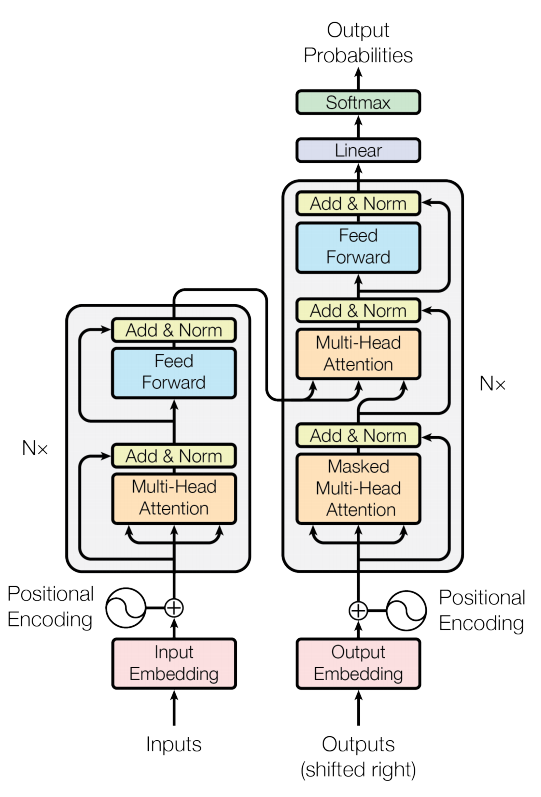

In [3]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator

    def forward(self, src, tgt, src_mask, tgt_mask):
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)

    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

## 1.2 Generator

`Generator` helps us to convert outputs to the probabilities vector.
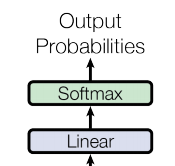

In [4]:
class Generator(nn.Module):
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return log_softmax(self.proj(x), dim=-1)

## 1.3 Encoder

### 1.3.1 Encoder

`Encoder` defines the layout of the whole encoder. In encoder, input data go through several encoder layers one by one, and then a normalization layer.
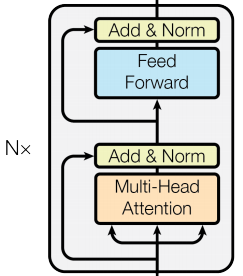

In [5]:
class Encoder(nn.Module):
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

### 1.3.2 Normalization Layer

`LayerNorm` defines a z-socre normalization layer.
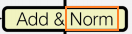

In [6]:
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        print(x.shape, mean.shape, std.shape)
        print(self.a_2.shape, self.b_2.shape)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

### 1.3.3 Connection of Sublayers

`SublayerConnection` simply add result and normolized result together.
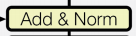

In [8]:
class SublayerConnection(nn.Module):
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

### 1.3.4 Encoder Layer

Each encoder layer consists of a self-attention layer and a feed forward layer. And every sublayer is wrapped by `SublayerConnection` which is responsible for the addition and normalization process.
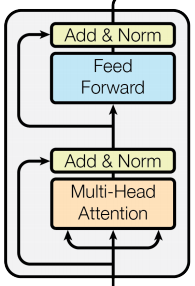

In [9]:
class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

## 1.4 Decoder

### 1.4.1 Decoder

Similar to `Encoder`, `Decoder` defines the whole decorder, in which output data and encoded input data go through decoder layers one by one, and then a normalization layer.
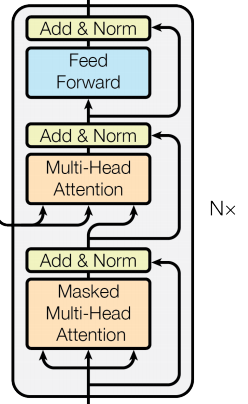

In [10]:
class Decoder(nn.Module):
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

### 1.4.2 Decoder Layer

Each decoder layer consists of a self-attention layer, a input-attention layer and a feed forward layer. Every sublayer is wrapped by `SublayerConnection`.
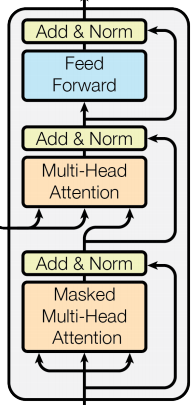

In [11]:
class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)

    def forward(self, x, memory, src_mask, tgt_mask):
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

## 1.5 Mask

In decoder, we need to mask out subsequent positions.
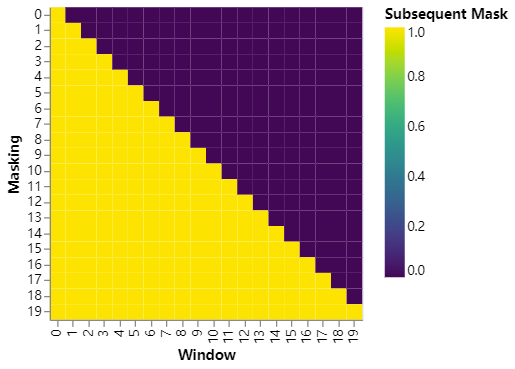

In [12]:
def subsequent_mask(size):
    attn_shape = (1, size, size)
    subsequent_mask = torch.triu(torch.ones(attn_shape), diagonal=1).type(
        torch.uint8
    )
    return subsequent_mask == 0

## 1.6 Attention Layer

### 1.6.1 Scaled Dot Product Attention

In each attention layer, we should calculate the scaled dot product attention:
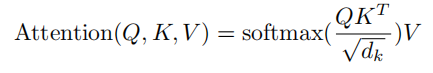

In [14]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = scores.softmax(dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

### 1.6.2 Multi-Head Attention

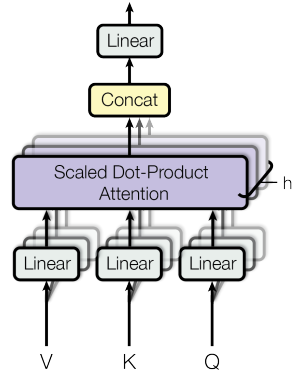
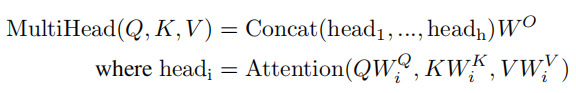

In [15]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        if mask is not None:
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)

        # 1) Generate [512,h*64] qeury, key and value matrix using linear process
        # and split into h heads, like [512, head_index, 64]
        query, key, value = [
            lin(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
            for lin, x in zip(self.linears, (query, key, value))
        ]
        # 2) Calculate attention seperately
        x, self.attn = attention(
            query, key, value, mask=mask, dropout=self.dropout
        )

        # 3) Concat heads together
        x = (
            x.transpose(1, 2)
            .contiguous()
            .view(nbatches, -1, self.h * self.d_k)
        )
        del query
        del key
        del value
        
        # 4) Multiply W_O
        return self.linears[-1](x)

## 1.7 Feed Forward Layer

A feed forward layer is simply a implementation of FNN function.
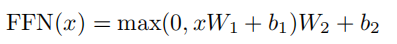

In [16]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(self.w_1(x).relu()))

## 1.8 Embedding Layer

Embedding layer will reduce the dimension of original d_model vector, to increase the information density and improve accuracy and performance.

In [17]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

## 1.9 Positional Encoding

Add positional information to input and output vectors, using the PE function:
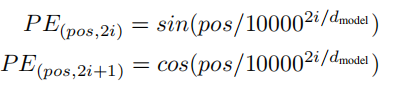

In [18]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute in log space
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1)].requires_grad_(False)
        return self.dropout(x)

## 1.10 The Full Model

In [20]:
def make_model(
    src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1
):
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab),
    )

    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

# 2. Model Training

## 2.1 Batches

In [23]:
class Batch:
    def __init__(self, src, tgt=None, pad=2):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if tgt is not None:
            self.tgt = tgt[:, :-1]
            self.tgt_y = tgt[:, 1:]
            self.tgt_mask = self.make_std_mask(self.tgt, pad)
            self.ntokens = (self.tgt_y != pad).data.sum()

    @staticmethod
    def make_std_mask(tgt, pad):
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & subsequent_mask(tgt.size(-1)).type_as(
            tgt_mask.data
        )
        return tgt_mask

## 2.2 Loop

In [24]:
class TrainState:
    step: int = 0
    accum_step: int = 0
    samples: int = 0
    tokens: int = 0

In [25]:
def run_epoch(
    data_iter,
    model,
    loss_compute,
    optimizer,
    scheduler,
    mode="train",
    accum_iter=1,
    train_state=TrainState(),
):
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    n_accum = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(
            batch.src, batch.tgt, batch.src_mask, batch.tgt_mask
        )
        loss, loss_node = loss_compute(out, batch.tgt_y, batch.ntokens)
        if mode == "train" or mode == "train+log":
            loss_node.backward()
            train_state.step += 1
            train_state.samples += batch.src.shape[0]
            train_state.tokens += batch.ntokens
            if i % accum_iter == 0:
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)
                n_accum += 1
                train_state.accum_step += 1
            scheduler.step()

        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 40 == 1 and (mode == "train" or mode == "train+log"):
            lr = optimizer.param_groups[0]["lr"]
            elapsed = time.time() - start
            print(
                (
                    "Epoch Step: %6d | Accumulation Step: %3d | Loss: %6.2f "
                    + "| Tokens / Sec: %7.1f | Learning Rate: %6.1e"
                )
                % (i, n_accum, loss / batch.ntokens, tokens / elapsed, lr)
            )
            start = time.time()
            tokens = 0
        del loss
        del loss_node
    return total_loss / total_tokens, train_state

## 2.3 Optimization

In [26]:
def rate(step, model_size, factor, warmup):
    if step == 0:
        step = 1
    return factor * (
        model_size ** (-0.5) * min(step ** (-0.5), step * warmup ** (-1.5))
    )

## 2.4 Regularization

In [27]:
class LabelSmoothing(nn.Module):
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(reduction="sum")
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None

    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, true_dist.clone().detach())

# 3. Run the Task

In this experiment, we will try de-en translation task.

## 3.1 Data Loading

We will load the dataset from torchtext, and spacy as tokenizer.

In [33]:
def load_tokenizers():
    try:
        spacy_de = spacy.load("de_dep_news_trf")
    except IOError:
        os.system("python -m spacy download de_dep_news_trf")
        spacy_de = spacy.load("de_dep_news_trf")

    try:
        spacy_en = spacy.load("en_core_web_trf")
    except IOError:
        os.system("python -m spacy download en_core_web_trf")
        spacy_en = spacy.load("en_core_web_trf")

    return spacy_de, spacy_en

In [ ]:
def tokenize(text, tokenizer):
    return [tok.text for tok in tokenizer.tokenizer(text)]


def yield_tokens(data_iter, tokenizer, index):
    for from_to_tuple in data_iter:
        yield tokenizer(from_to_tuple[index])

In [ ]:
def build_vocabulary(spacy_de, spacy_en):
    def tokenize_de(text):
        return tokenize(text, spacy_de)

    def tokenize_en(text):
        return tokenize(text, spacy_en)

    print("Building German Vocabulary ...")
    train, val, test = datasets.Multi30k(language_pair=("de", "en"))
    vocab_src = build_vocab_from_iterator(
        yield_tokens(train + val + test, tokenize_de, index=0),
        min_freq=2,
        specials=["<s>", "</s>", "<blank>", "<unk>"],
    )

    print("Building English Vocabulary ...")
    train, val, test = datasets.Multi30k(language_pair=("de", "en"))
    vocab_tgt = build_vocab_from_iterator(
        yield_tokens(train + val + test, tokenize_en, index=1),
        min_freq=2,
        specials=["<s>", "</s>", "<blank>", "<unk>"],
    )

    vocab_src.set_default_index(vocab_src["<unk>"])
    vocab_tgt.set_default_index(vocab_tgt["<unk>"])

    return vocab_src, vocab_tgt


def load_vocab(spacy_de, spacy_en):
    if not exists("vocab.pt"):
        vocab_src, vocab_tgt = build_vocabulary(spacy_de, spacy_en)
        torch.save((vocab_src, vocab_tgt), "vocab.pt")
    else:
        vocab_src, vocab_tgt = torch.load("vocab.pt")
    print("Finished.\nVocabulary sizes:")
    print(len(vocab_src))
    print(len(vocab_tgt))
    return vocab_src, vocab_tgt


spacy_de, spacy_en = load_tokenizers()
vocab_src, vocab_tgt = load_vocab(spacy_de, spacy_en)

## 3.2 Iterators

In [ ]:
def collate_batch(
    batch,
    src_pipeline,
    tgt_pipeline,
    src_vocab,
    tgt_vocab,
    device,
    max_padding=128,
    pad_id=2,
):
    bs_id = torch.tensor([0], device=device)
    eos_id = torch.tensor([1], device=device)
    src_list, tgt_list = [], []
    for (_src, _tgt) in batch:
        processed_src = torch.cat(
            [
                bs_id,
                torch.tensor(
                    src_vocab(src_pipeline(_src)),
                    dtype=torch.int64,
                    device=device,
                ),
                eos_id,
            ],
            0,
        )
        processed_tgt = torch.cat(
            [
                bs_id,
                torch.tensor(
                    tgt_vocab(tgt_pipeline(_tgt)),
                    dtype=torch.int64,
                    device=device,
                ),
                eos_id,
            ],
            0,
        )
        src_list.append(
            pad(
                processed_src,
                (
                    0,
                    max_padding - len(processed_src),
                ),
                value=pad_id,
            )
        )
        tgt_list.append(
            pad(
                processed_tgt,
                (0, max_padding - len(processed_tgt)),
                value=pad_id,
            )
        )

    src = torch.stack(src_list)
    tgt = torch.stack(tgt_list)
    return (src, tgt)

In [ ]:
def create_dataloaders(
    device,
    vocab_src,
    vocab_tgt,
    spacy_de,
    spacy_en,
    batch_size=12000,
    max_padding=128,
    is_distributed=True,
):
    # def create_dataloaders(batch_size=12000):
    def tokenize_de(text):
        return tokenize(text, spacy_de)

    def tokenize_en(text):
        return tokenize(text, spacy_en)

    def collate_fn(batch):
        return collate_batch(
            batch,
            tokenize_de,
            tokenize_en,
            vocab_src,
            vocab_tgt,
            device,
            max_padding=max_padding,
            pad_id=vocab_src.get_stoi()["<blank>"],
        )

    train_iter, valid_iter, test_iter = datasets.Multi30k(
        language_pair=("de", "en")
    )

    train_iter_map = to_map_style_dataset(
        train_iter
    )  # DistributedSampler needs a dataset len()
    train_sampler = (
        DistributedSampler(train_iter_map) if is_distributed else None
    )
    valid_iter_map = to_map_style_dataset(valid_iter)
    valid_sampler = (
        DistributedSampler(valid_iter_map) if is_distributed else None
    )

    train_dataloader = DataLoader(
        train_iter_map,
        batch_size=batch_size,
        shuffle=(train_sampler is None),
        sampler=train_sampler,
        collate_fn=collate_fn,
    )
    valid_dataloader = DataLoader(
        valid_iter_map,
        batch_size=batch_size,
        shuffle=(valid_sampler is None),
        sampler=valid_sampler,
        collate_fn=collate_fn,
    )
    return train_dataloader, valid_dataloader

## 3.3 Training

In [ ]:
def train_worker(
    gpu,
    ngpus_per_node,
    vocab_src,
    vocab_tgt,
    spacy_de,
    spacy_en,
    config,
    is_distributed=False,
):
    print(f"Train worker process using GPU: {gpu} for training", flush=True)
    torch.cuda.set_device(gpu)

    pad_idx = vocab_tgt["<blank>"]
    d_model = 512
    model = make_model(len(vocab_src), len(vocab_tgt), N=6)
    model.cuda(gpu)
    module = model
    is_main_process = True
    if is_distributed:
        dist.init_process_group(
            "nccl", init_method="env://", rank=gpu, world_size=ngpus_per_node
        )
        model = DDP(model, device_ids=[gpu])
        module = model.module
        is_main_process = gpu == 0

    criterion = LabelSmoothing(
        size=len(vocab_tgt), padding_idx=pad_idx, smoothing=0.1
    )
    criterion.cuda(gpu)

    train_dataloader, valid_dataloader = create_dataloaders(
        gpu,
        vocab_src,
        vocab_tgt,
        spacy_de,
        spacy_en,
        batch_size=config["batch_size"] // ngpus_per_node,
        max_padding=config["max_padding"],
        is_distributed=is_distributed,
    )

    optimizer = torch.optim.Adam(
        model.parameters(), lr=config["base_lr"], betas=(0.9, 0.98), eps=1e-9
    )
    lr_scheduler = LambdaLR(
        optimizer=optimizer,
        lr_lambda=lambda step: rate(
            step, d_model, factor=1, warmup=config["warmup"]
        ),
    )
    train_state = TrainState()

    for epoch in range(config["num_epochs"]):
        if is_distributed:
            train_dataloader.sampler.set_epoch(epoch)
            valid_dataloader.sampler.set_epoch(epoch)

        model.train()
        print(f"[GPU{gpu}] Epoch {epoch} Training ====", flush=True)
        _, train_state = run_epoch(
            (Batch(b[0], b[1], pad_idx) for b in train_dataloader),
            model,
            SimpleLossCompute(module.generator, criterion),
            optimizer,
            lr_scheduler,
            mode="train+log",
            accum_iter=config["accum_iter"],
            train_state=train_state,
        )

        GPUtil.showUtilization()
        if is_main_process:
            file_path = "%s%.2d.pt" % (config["file_prefix"], epoch)
            torch.save(module.state_dict(), file_path)
        torch.cuda.empty_cache()

        print(f"[GPU{gpu}] Epoch {epoch} Validation ====", flush=True)
        model.eval()
        sloss = run_epoch(
            (Batch(b[0], b[1], pad_idx) for b in valid_dataloader),
            model,
            SimpleLossCompute(module.generator, criterion),
            DummyOptimizer(),
            DummyScheduler(),
            mode="eval",
        )
        print(sloss)
        torch.cuda.empty_cache()

    if is_main_process:
        file_path = "%sfinal.pt" % config["file_prefix"]
        torch.save(module.state_dict(), file_path)

In [ ]:
def train_distributed_model(vocab_src, vocab_tgt, spacy_de, spacy_en, config):
    from the_annotated_transformer import train_worker

    ngpus = torch.cuda.device_count()
    os.environ["MASTER_ADDR"] = "localhost"
    os.environ["MASTER_PORT"] = "12356"
    print(f"Number of GPUs detected: {ngpus}")
    print("Spawning training processes ...")
    mp.spawn(
        train_worker,
        nprocs=ngpus,
        args=(ngpus, vocab_src, vocab_tgt, spacy_de, spacy_en, config, True),
    )


def train_model(vocab_src, vocab_tgt, spacy_de, spacy_en, config):
    if config["distributed"]:
        train_distributed_model(
            vocab_src, vocab_tgt, spacy_de, spacy_en, config
        )
    else:
        train_worker(
            0, 1, vocab_src, vocab_tgt, spacy_de, spacy_en, config, False
        )


def load_trained_model():
    config = {
        "batch_size": 32,
        "distributed": False,
        "num_epochs": 8,
        "accum_iter": 10,
        "base_lr": 1.0,
        "max_padding": 72,
        "warmup": 3000,
        "file_prefix": "multi30k_model_",
    }
    model_path = "multi30k_model_final.pt"
    if not exists(model_path):
        train_model(vocab_src, vocab_tgt, spacy_de, spacy_en, config)

    model = make_model(len(vocab_src), len(vocab_tgt), N=6)
    model.load_state_dict(torch.load("multi30k_model_final.pt"))
    return model


model = load_trained_model()